In [2]:
import os
import pandas as pd

# Set the path to the data directory
data_path = "data"  # Change this to the actual path where your folders are stored

# Create an empty list to store individual apartment dataframes
all_data = []

# Loop through each year directory 2015
for year in ["2015"]:
    year_path = os.path.join(data_path, year)  # Path to the current year's folder
    
    # Check if the year path exists
    if not os.path.exists(year_path):
        continue  # Skip if the folder does not exist
    
    # Loop through each CSV file in the year's folder
    for file_name in os.listdir(year_path):
        if file_name.endswith(".csv"):  # Process only CSV files
            file_path = os.path.join(year_path, file_name)
            
            # Load the CSV file into a DataFrame without headers
            df = pd.read_csv(file_path, header=None)
            
            # Assign column names to the DataFrame
            df.columns = ["time", "energy_consumption"]  # Set the column names
            
            # Filter out rows where energy consumption is zero
            df = df[df["energy_consumption"] != 0]
            
            # Convert 'time' column to datetime format
            df["time"] = pd.to_datetime(df["time"])  # Adjust the format if needed
            
            # Add columns for year and apartment_id (extracted from file name)
            df["apartment_id"] = file_name.split('_')[0]  # Extract apartment ID from the file name
            df["apartment_id"] = df["apartment_id"].str.extract(r'(\d+)')
            # Append the filtered DataFrame to the list
            all_data.append(df)

# Combine all individual DataFrames into one DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_data.head())
combined_data.to_csv('combined_data.csv', index=False)

                 time  energy_consumption apartment_id
0 2015-01-01 00:00:00            1.942324           10
1 2015-01-01 00:15:00            1.515683           10
2 2015-01-01 00:30:00            1.926088           10
3 2015-01-01 00:45:00            1.797697           10
4 2015-01-01 01:00:00            1.474011           10


In [3]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Aggregate data by time intervals
monthly_energy = combined_data.groupby(['apartment_id', combined_data["time"].dt.month])['energy_consumption'].sum()
weekly_energy = combined_data.groupby(['apartment_id', combined_data["time"].dt.isocalendar().week])['energy_consumption'].sum()
daily_energy = combined_data.groupby(['apartment_id', combined_data["time"].dt.dayofyear])['energy_consumption'].sum()

print(monthly_energy)
print(weekly_energy)
print(daily_energy)


apartment_id  time
1             1        5812.097781
              2        4828.371691
              3        4306.390459
              4        1701.514563
              5         219.256570
                          ...     
9             8        2065.951804
              9        1675.939054
              10       3844.557433
              11       5317.450643
              12      49478.103593
Name: energy_consumption, Length: 588, dtype: float64
apartment_id  week
1             1         775.487879
              2        1677.397722
              3        1280.499760
              4        1027.291708
              5        1219.714092
                          ...     
9             49       1550.020077
              50       1397.783453
              51      16364.936696
              52      17516.576683
              53      12900.991417
Name: energy_consumption, Length: 2588, dtype: float64
apartment_id  time
1             1        211.702027
              2        182.914

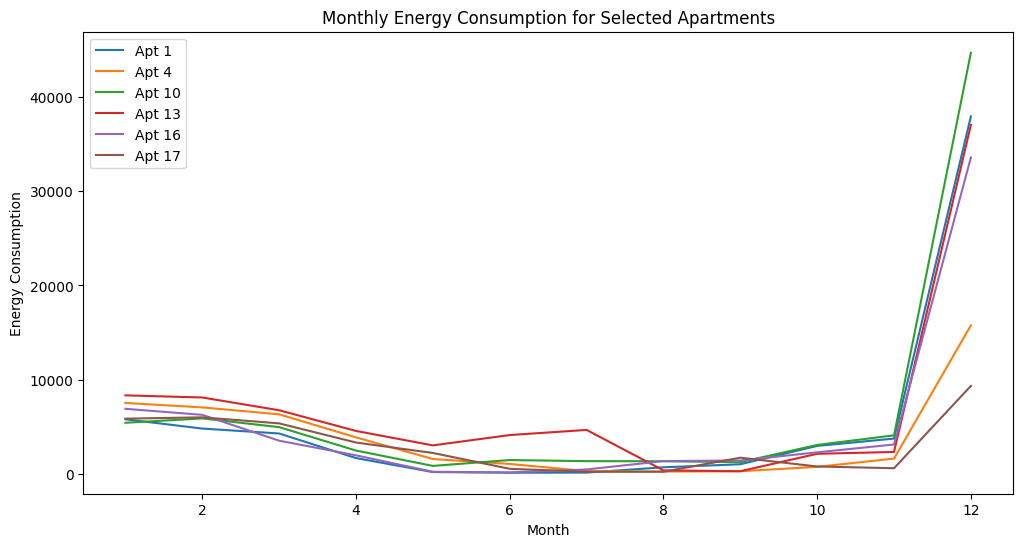

In [4]:
# List of apartment IDs to plot
apartments_to_plot = ['1', '4', '10', '13', '16', '17']

# Reset the index to access the data correctly
monthly_energy_reset = monthly_energy.reset_index()

plt.figure(figsize=(12, 6))
for apartment_id in apartments_to_plot:
    apartment_data = monthly_energy_reset[monthly_energy_reset['apartment_id'] == apartment_id]
    plt.plot(apartment_data['time'], apartment_data['energy_consumption'], label=f'Apt {apartment_id}')

plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.title('Monthly Energy Consumption for Selected Apartments')
plt.legend()
plt.show()

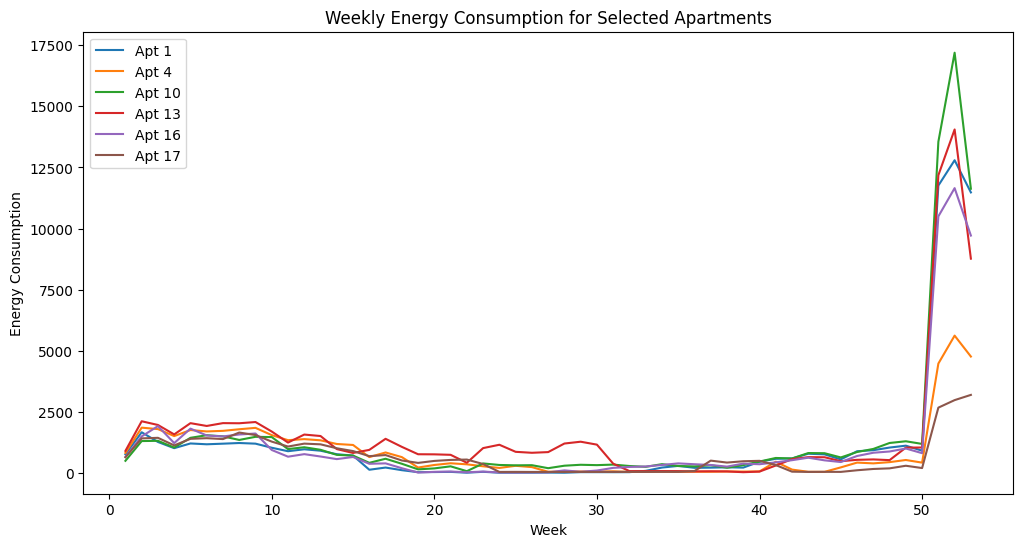

In [5]:
# List of apartment IDs to plot
apartments_to_plot = ['1', '4', '10', '13', '16', '17']

# Reset the index to access the data correctly
weekly_energy_reset = weekly_energy.reset_index()

plt.figure(figsize=(12, 6))
for apartment_id in apartments_to_plot:
    apartment_data = weekly_energy_reset[weekly_energy_reset['apartment_id'] == apartment_id]
    plt.plot(apartment_data['week'], apartment_data['energy_consumption'], label=f'Apt {apartment_id}')

plt.xlabel('Week')
plt.ylabel('Energy Consumption')
plt.title('Weekly Energy Consumption for Selected Apartments')
plt.legend()
plt.show()

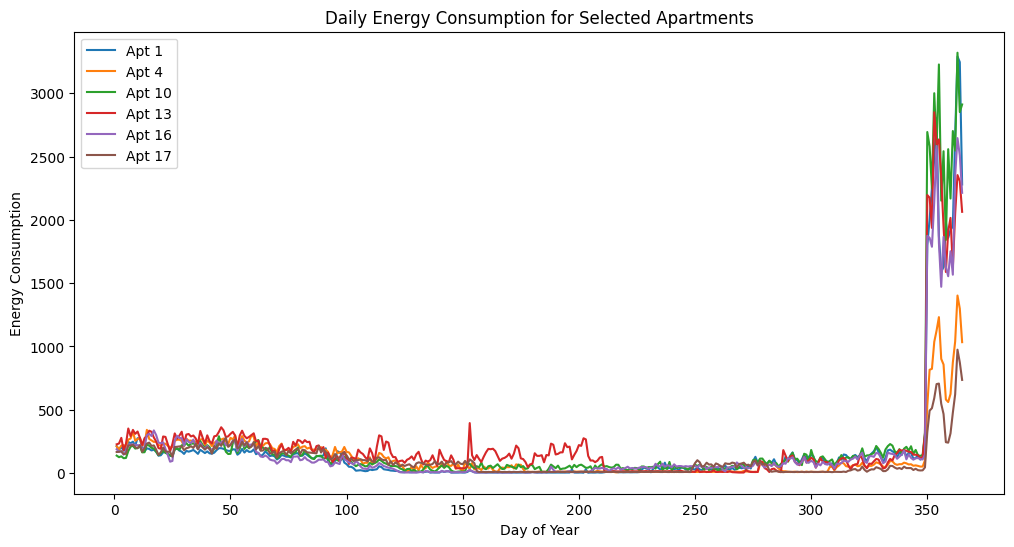

In [6]:
# List of apartment IDs to plot
apartments_to_plot = ['1', '4', '10', '13', '16', '17']

# Reset the index to access the data correctly
daily_energy_reset = daily_energy.reset_index()

plt.figure(figsize=(12, 6))
for apartment_id in apartments_to_plot:
    apartment_data = daily_energy_reset[daily_energy_reset['apartment_id'] == apartment_id]
    plt.plot(apartment_data['time'], apartment_data['energy_consumption'], label=f'Apt {apartment_id}')

plt.xlabel('Day of Year')
plt.ylabel('Energy Consumption')
plt.title('Daily Energy Consumption for Selected Apartments')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Monthly Correlation Heatmap')

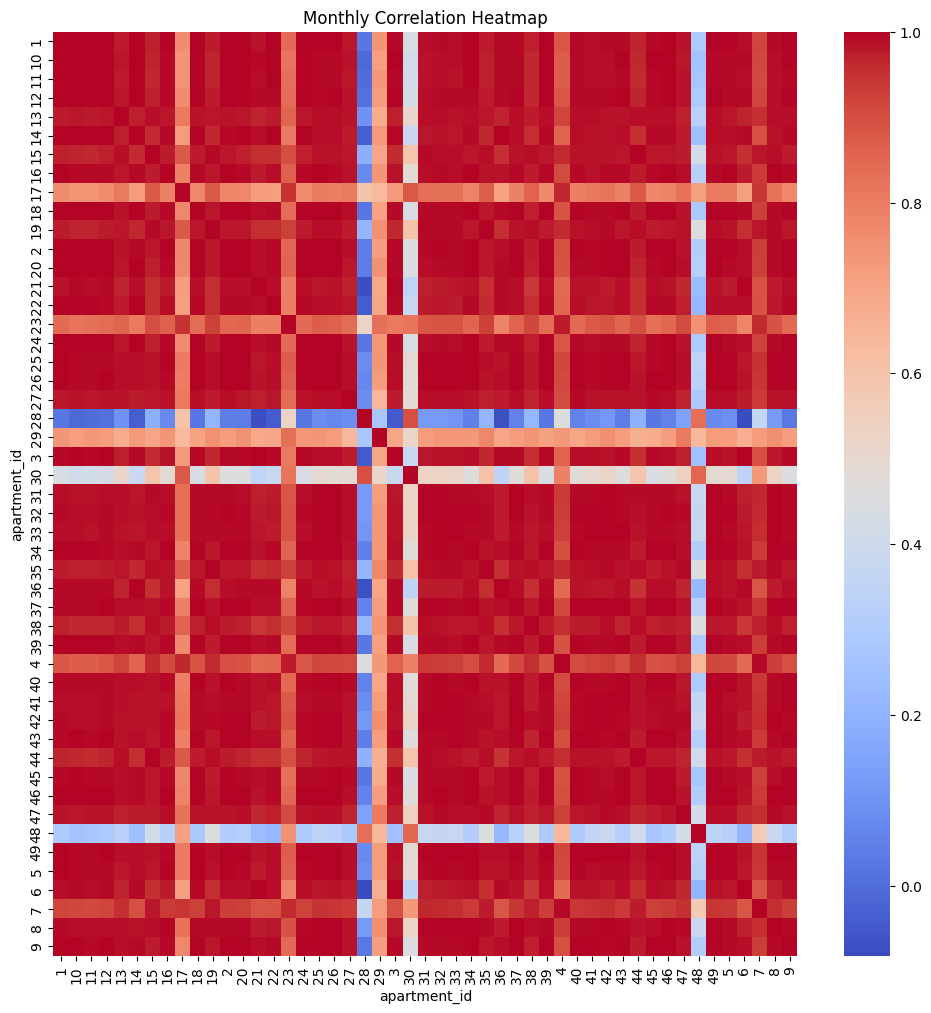

In [18]:
# Reshape data for correlation
monthly_energy = monthly_energy.unstack(level=0).fillna(0)
weekly_energy = weekly_energy.unstack(level=0).fillna(0)
daily_energy = daily_energy.unstack(level=0).fillna(0)

# Compute correlation matrices
monthly_corr = monthly_energy.corr()
weekly_corr = weekly_energy.corr()
daily_corr = daily_energy.corr()


# Visualize correlation matrices
plt.figure(figsize=(12,12))
sns.heatmap(monthly_corr, annot=False, cmap='coolwarm')
plt.title('Monthly Correlation Heatmap')

Text(0.5, 1.0, 'Weekly Correlation Heatmap')

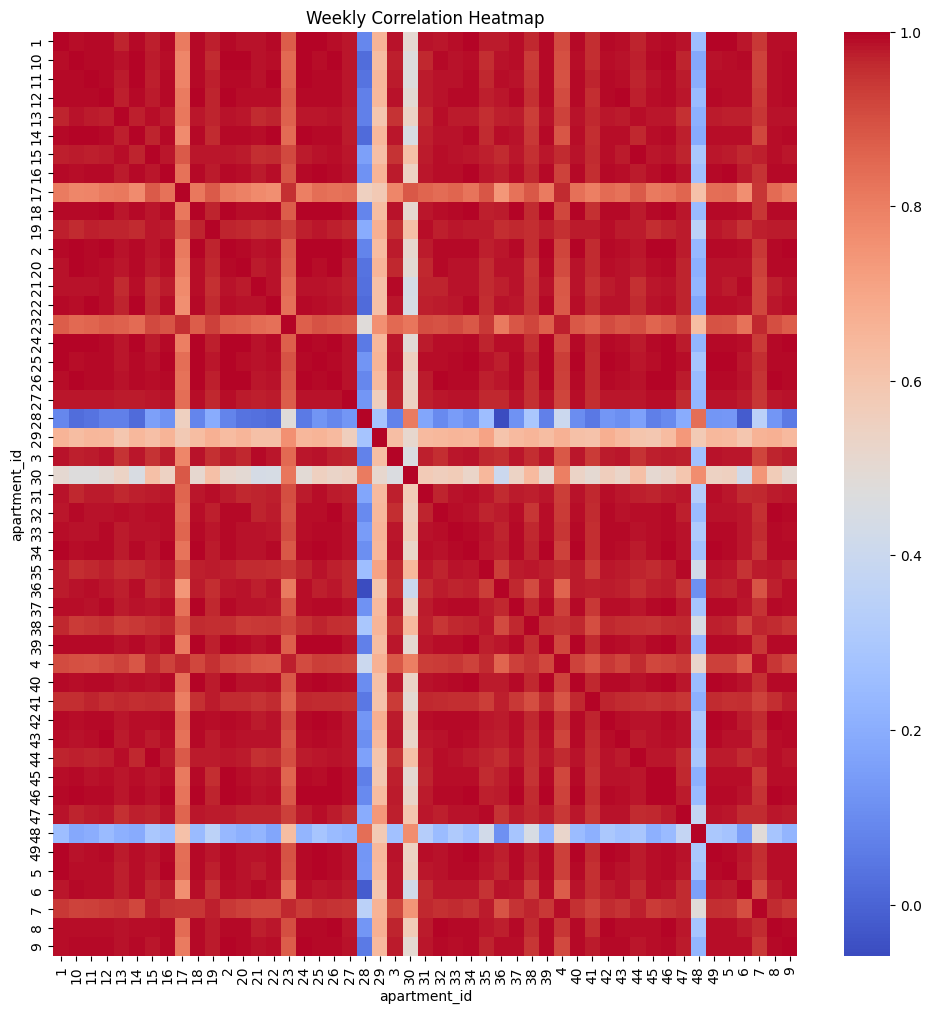

In [19]:
plt.figure(figsize=(12,12))
sns.heatmap(weekly_corr, annot=False, cmap='coolwarm')
plt.title('Weekly Correlation Heatmap')

Text(0.5, 1.0, 'Daily Correlation Heatmap')

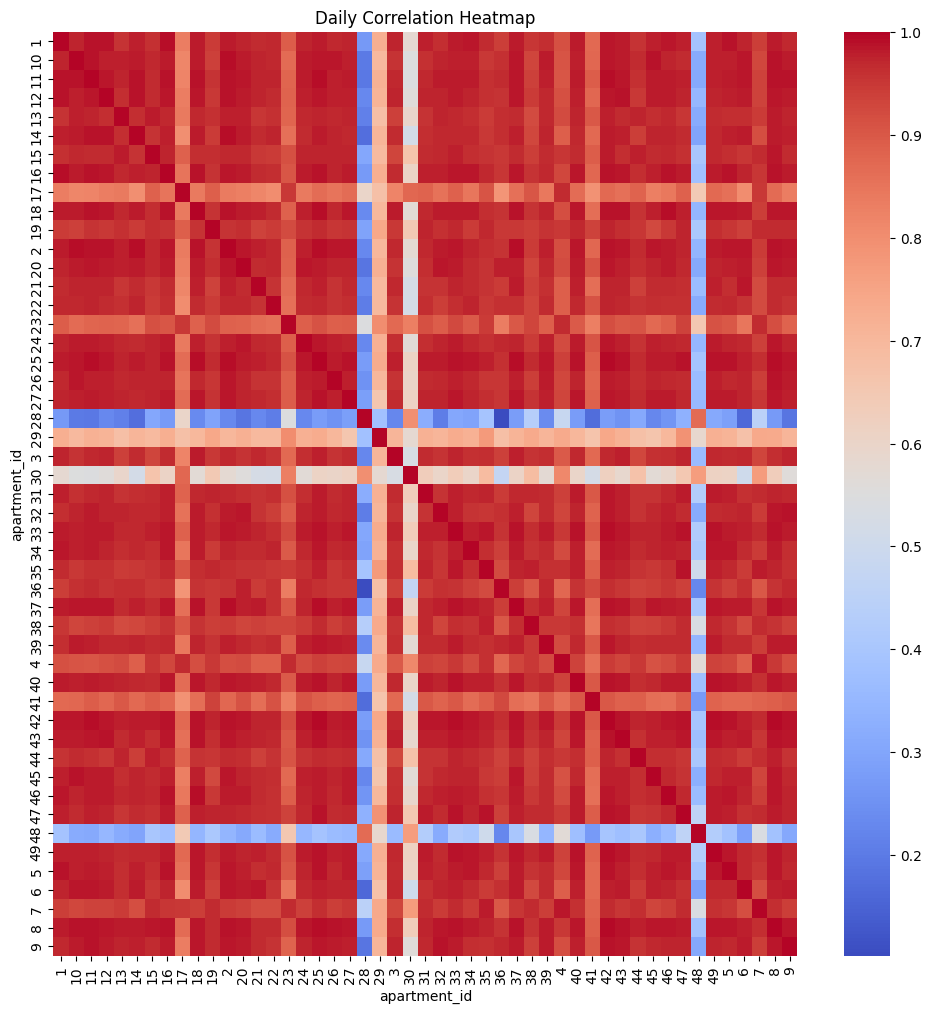

In [20]:
plt.figure(figsize=(12,12))
sns.heatmap(daily_corr, annot=False, cmap='coolwarm')
plt.title('Daily Correlation Heatmap')

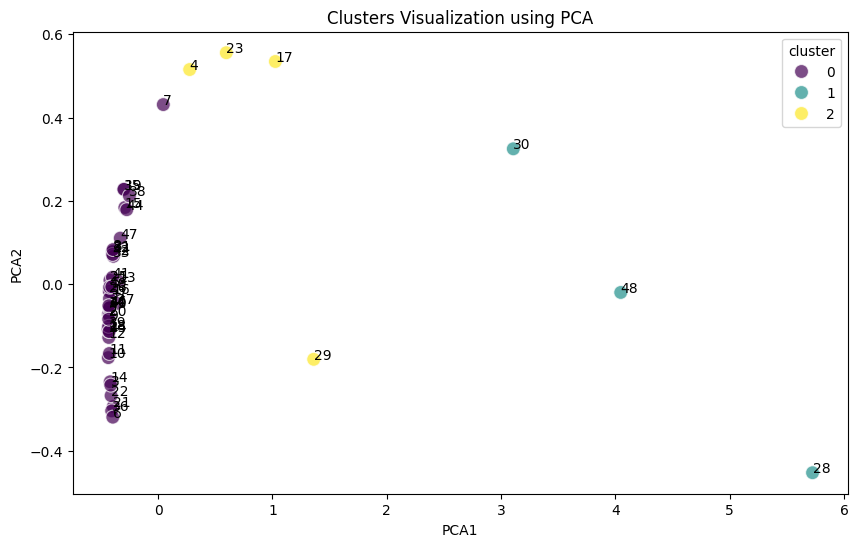

In [10]:
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA


def perform_clustering_monthly(corr_matrix, n_clusters=3):
    # Apply K-Means clustering on the correlation matrix
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(corr_matrix)
    
    # Map apartments to their clusters
    apartment_clusters = {apartment: clusters[i] for i, apartment in enumerate(corr_matrix.columns)}
    
    return apartment_clusters

def plot_clusters_scatter_monthly(corr_matrix, apartment_clusters):
    # Create a DataFrame for the clusters
    cluster_df = corr_matrix.copy()
    cluster_df['cluster'] = [apartment_clusters[apartment] for apartment in corr_matrix.columns]
    
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(corr_matrix)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = cluster_df['cluster'].values
    pca_df['apartment_id'] = corr_matrix.columns
        
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
        
    # Add labels for each point
    for i in range(pca_df.shape[0]):
        plt.text(pca_df['PCA1'][i], pca_df['PCA2'][i], pca_df['apartment_id'][i], fontsize=10)
        
    plt.title('Clusters Visualization using PCA')
    plt.show()

# Cluster assignment for each apartment
apartment_clusters = perform_clustering_monthly(monthly_corr)
# Plot the clusters
plot_clusters_scatter_monthly(monthly_corr, apartment_clusters)

Kernel Ridge Regression Model Score: -0.28282962662444855
Kernel Ridge Regression Model Score: 0.8982901755853623
Kernel Ridge Regression Model Score: -1.5622786165334586


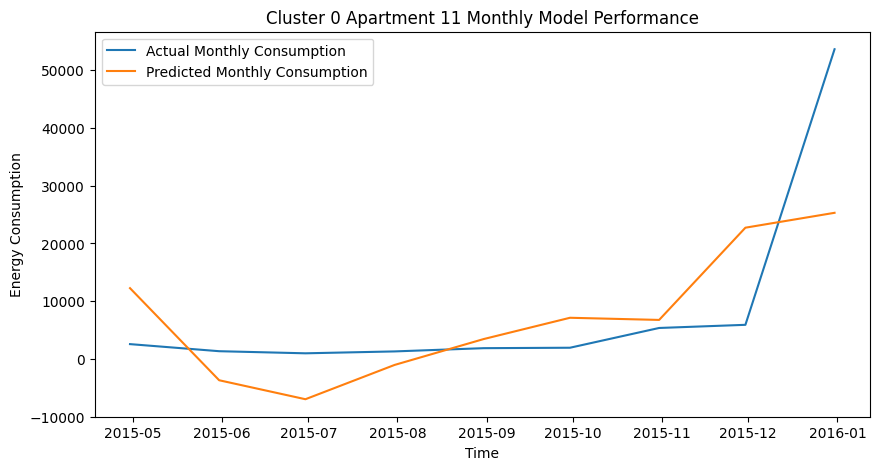

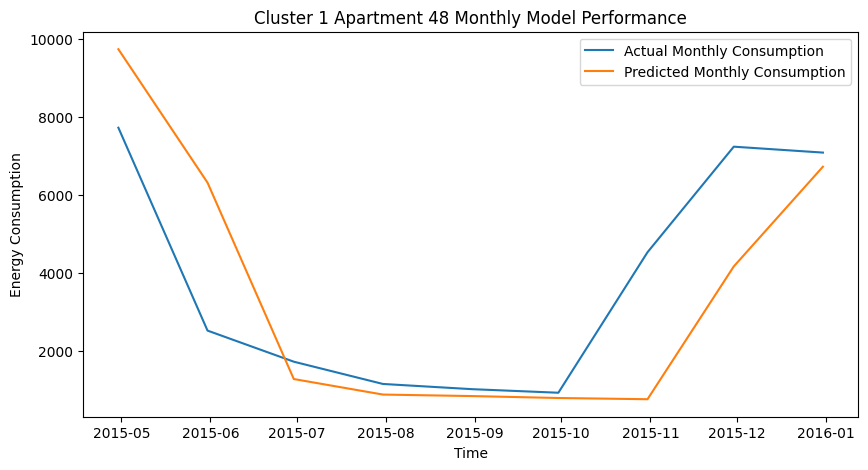

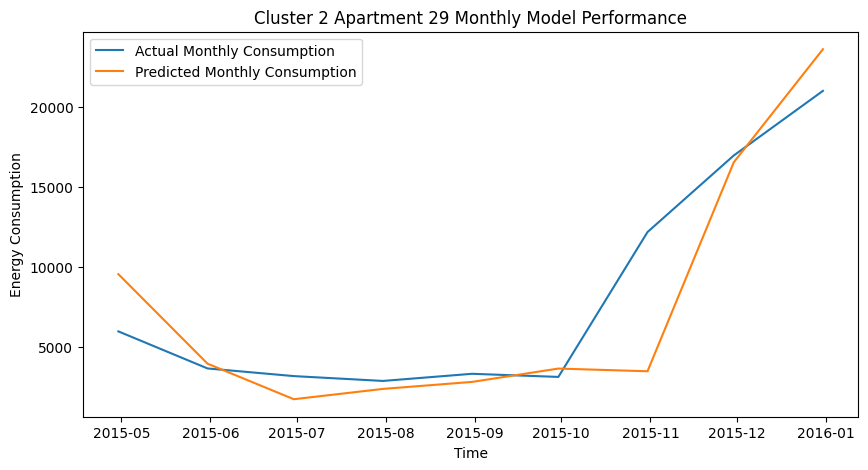

In [23]:
# Function to pull relevant data and train models for each cluster
def monthly_cluster_specific_modeling(combined_data, apartment_clusters, n_clusters=3):
    cluster_models = {}
    
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        # Filter data for relevant apartments in this cluster
        cluster_data = combined_data[combined_data['apartment_id'].isin(cluster_apartments)]
        
        # Resample data to monthly aggregations for each apartment
        cluster_data.set_index('time', inplace=True)
        
        monthly_data = cluster_data.groupby('apartment_id')['energy_consumption'].resample('ME').sum().reset_index()
        
        # Feature engineering - adding lagged features to monthly data
        monthly_data = add_lagged_features_monthly(monthly_data, lags=[1, 3])
        
        # Drop rows with NaN values from lagged features
        monthly_data = monthly_data.dropna()
        
        # Prepare training and testing sets for monthly data
        X_monthly = monthly_data[['lag_1', 'lag_3']]
        y_monthly = monthly_data['energy_consumption']
        X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=0.2, random_state=42)
        
        # Train a Kernel Ridge Regression model for monthly data
        monthly_model = fit_kernel_ridge_model_monthly(X_train_monthly, y_train_monthly, X_test_monthly, y_test_monthly)
        
        # Store models for each cluster
        cluster_models[cluster] = {'monthly_model': monthly_model}
    
    return cluster_models

# Function to add lagged features
def add_lagged_features_monthly(combined_data, lags=[1, 3]):
    for lag in lags:
        combined_data[f'lag_{lag}'] = combined_data.groupby('apartment_id')['energy_consumption'].shift(lag)
    return combined_data

# Function to fit Kernel Ridge Regression model
def fit_kernel_ridge_model_monthly(X_train, y_train, X_test, y_test, alpha=0.1, gamma=0.1):
    # Initialize and fit the Kernel Ridge Regression model
    kr_model = KernelRidge(alpha=alpha, gamma=gamma)
    kr_model.fit(X_train, y_train)
    
    # Evaluate the model
    score = kr_model.score(X_test, y_test)
    print(f"Kernel Ridge Regression Model Score: {score}")
    
    return kr_model

# Train models for each cluster
cluster_models = monthly_cluster_specific_modeling(combined_data, apartment_clusters)

# Visualize the model performance
def visualize_model_performance_monthly(cluster_models, combined_data, apartment_clusters, n_clusters=3):
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        if cluster_apartments:
            apartment = cluster_apartments[2]  # Select one apartment from the cluster
            # Filter data for the relevant apartment in this cluster
            apartment_data = combined_data[combined_data['apartment_id'] == apartment]
            
            # Resample data to monthly aggregations for the apartment
            apartment_data.set_index('time', inplace=True)
            monthly_data = apartment_data['energy_consumption'].resample('ME').sum().reset_index()
            
            # Ensure monthly_data has apartment_id as a column
            monthly_data['apartment_id'] = apartment
            # Feature engineering - adding lagged features to monthly data
            monthly_data = add_lagged_features_monthly(monthly_data, lags=[1, 3])
            
            # Drop rows with NaN values from lagged features
            monthly_data = monthly_data.dropna()
            
            # Prepare data for monthly model visualization
            X_monthly = monthly_data[['lag_1', 'lag_3']]
            y_monthly = monthly_data['energy_consumption']
            monthly_model = cluster_models[cluster]['monthly_model']
            y_pred_monthly = monthly_model.predict(X_monthly)
            
            # Plot monthly model performance for the apartment
            plt.figure(figsize=(10, 5))
            plt.plot(monthly_data['time'], y_monthly, label='Actual Monthly Consumption')
            plt.plot(monthly_data['time'], y_pred_monthly, label='Predicted Monthly Consumption')
            plt.title(f'Cluster {cluster} Apartment {apartment} Monthly Model Performance')
            plt.xlabel('Time')
            plt.ylabel('Energy Consumption')
            plt.legend()
            plt.show()

# Visualize the model performance for each apartment in each cluster
visualize_model_performance_monthly(cluster_models, combined_data, apartment_clusters)

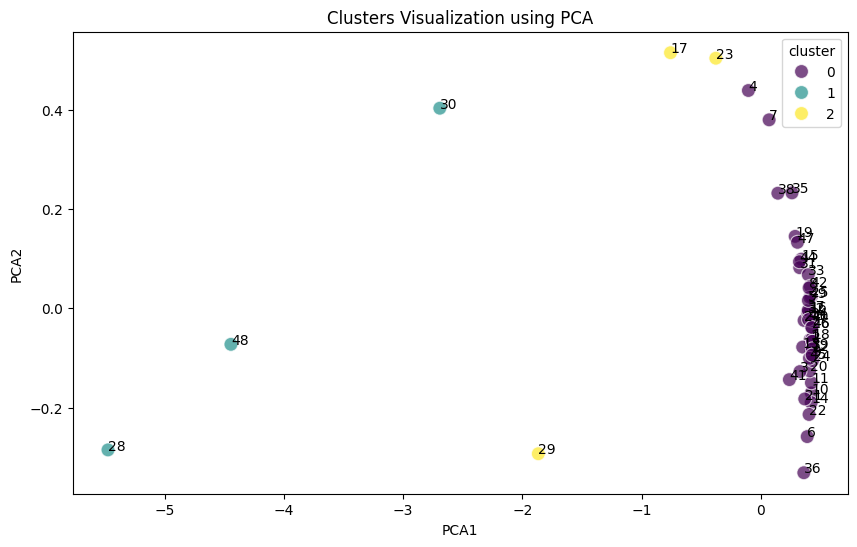

In [12]:
def perform_clustering_weekly(corr_matrix, n_clusters=3):
    # Apply K-Means clustering on the correlation matrix
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(corr_matrix)
    
    # Map apartments to their clusters
    apartment_clusters = {apartment: clusters[i] for i, apartment in enumerate(corr_matrix.columns)}
    
    return apartment_clusters

def plot_clusters_scatter_weekly(corr_matrix, apartment_clusters):
    # Create a DataFrame for the clusters
    cluster_df = corr_matrix.copy()
    cluster_df['cluster'] = [apartment_clusters[apartment] for apartment in corr_matrix.columns]
    
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(corr_matrix)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = cluster_df['cluster'].values
    pca_df['apartment_id'] = corr_matrix.columns
        
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
        
    # Add labels for each point
    for i in range(pca_df.shape[0]):
        plt.text(pca_df['PCA1'][i], pca_df['PCA2'][i], pca_df['apartment_id'][i], fontsize=10)
        
    plt.title('Clusters Visualization using PCA')
    plt.show()

# Cluster assignment for each apartment
apartment_clusters = perform_clustering_weekly(weekly_corr)
# Plot the clusters
plot_clusters_scatter_weekly(weekly_corr, apartment_clusters)

Kernel Ridge Regression Model Score: 0.4775206570429198
Kernel Ridge Regression Model Score: 0.9236728751334885
Kernel Ridge Regression Model Score: 0.8623329989776701


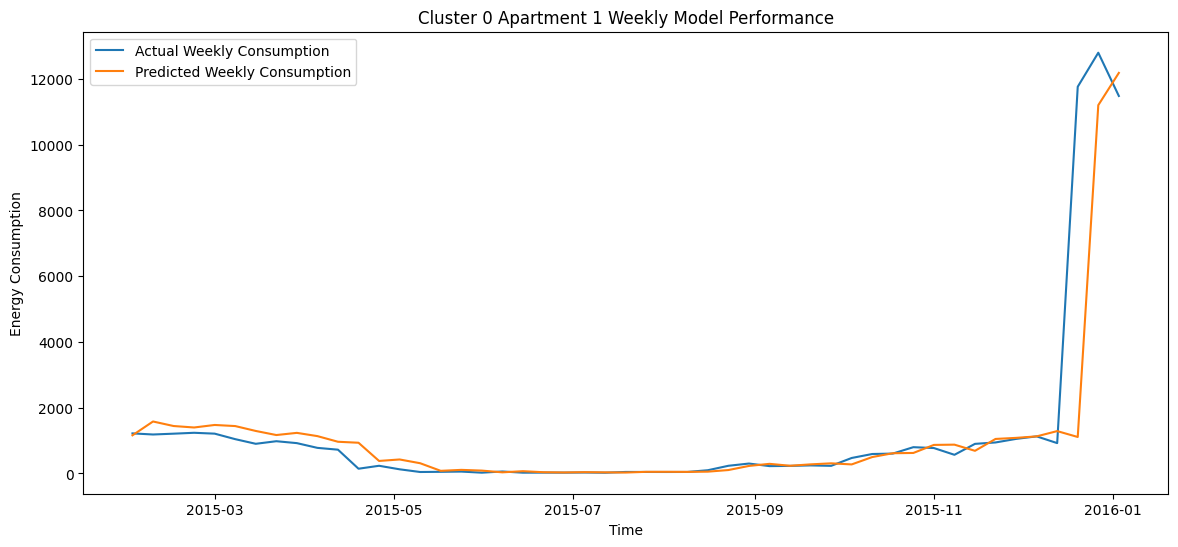

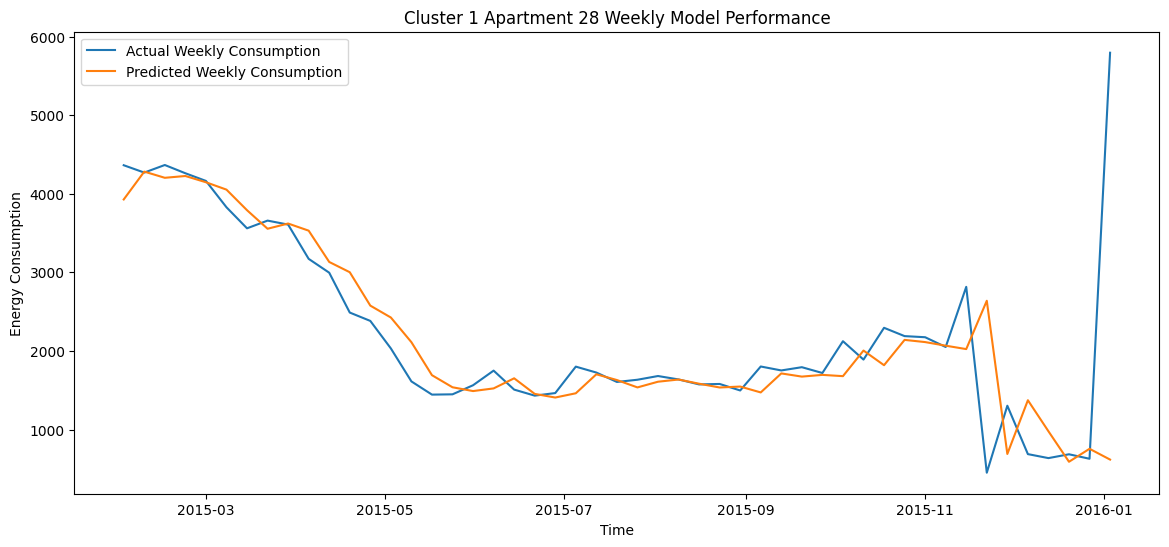

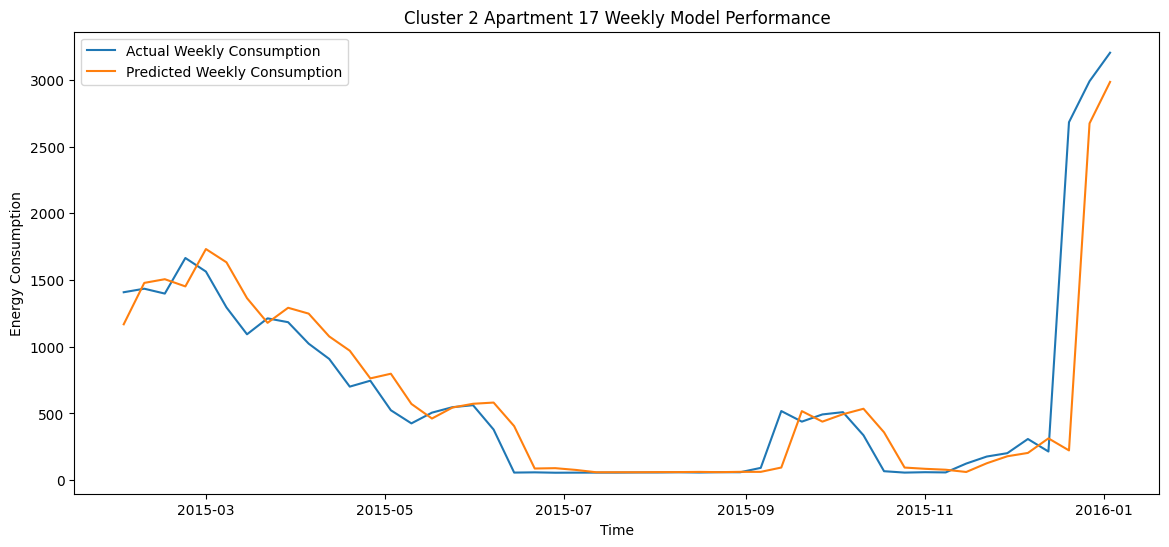

In [13]:
# Function to pull relevant data and train models for each cluster
def weekly_cluster_specific_modeling(combined_data, apartment_clusters, n_clusters=3):
    cluster_models = {}
    
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        # Filter data for relevant apartments in this cluster
        cluster_data = combined_data[combined_data['apartment_id'].isin(cluster_apartments)]
        
        # Resample data to daily and weekly aggregations for each apartment
        cluster_data.set_index('time', inplace=True)
        
        weekly_data = cluster_data.groupby('apartment_id')['energy_consumption'].resample('W').sum().reset_index()
        
        # Feature engineering - adding lagged features to daily and weekly data
        weekly_data = add_lagged_features_weekly(weekly_data, lags=[1, 4])
        
        # Drop rows with NaN values from lagged features
        weekly_data = weekly_data.dropna()
        
        # Prepare training and testing sets for weekly data
        X_weekly = weekly_data[['lag_1', 'lag_4']]
        y_weekly = weekly_data['energy_consumption']
        X_train_weekly, X_test_weekly, y_train_weekly, y_test_weekly = train_test_split(X_weekly, y_weekly, test_size=0.2, random_state=42)
        
        # Train a Kernel Ridge Regression model for weekly data
        weekly_model = fit_kernel_ridge_model_weekly(X_train_weekly, y_train_weekly, X_test_weekly, y_test_weekly)
        
        # Store models for each cluster
        cluster_models[cluster] = {'weekly_model': weekly_model}
    
    return cluster_models

# Function to add lagged features
def add_lagged_features_weekly(combined_data, lags=[1, 7]):
    for lag in lags:
        combined_data[f'lag_{lag}'] = combined_data.groupby('apartment_id')['energy_consumption'].shift(lag)
    return combined_data

# Function to fit Kernel Ridge Regression model
def fit_kernel_ridge_model_weekly(X_train, y_train, X_test, y_test, alpha=0.1, gamma=0.9):
    # Initialize and fit the Kernel Ridge Regression model
    kr_model = KernelRidge(alpha=alpha, gamma=gamma)
    kr_model.fit(X_train, y_train)
    
    # Evaluate the model
    score = kr_model.score(X_test, y_test)
    print(f"Kernel Ridge Regression Model Score: {score}")
    
    return kr_model

# Train models for each cluster
cluster_models = weekly_cluster_specific_modeling(combined_data, apartment_clusters)

# Visualize the model performance
def visualize_model_performance_weekly(cluster_models, combined_data, apartment_clusters, n_clusters=3):
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        if cluster_apartments:
            apartment = cluster_apartments[0]  # Select one apartment from the cluster
            # Filter data for the relevant apartment in this cluster
            apartment_data = combined_data[combined_data['apartment_id'] == apartment]
            
            # Resample data to weekly aggregations for the apartment
            apartment_data.set_index('time', inplace=True)
            weekly_data = apartment_data['energy_consumption'].resample('W').sum().reset_index()
            
            # Ensure weekly_data has apartment_id as a column
            weekly_data['apartment_id'] = apartment
            # Feature engineering - adding lagged features to weekly data
            weekly_data = add_lagged_features_weekly(weekly_data, lags=[1, 4])
            
            # Drop rows with NaN values from lagged features
            weekly_data = weekly_data.dropna()
            
            # Prepare data for weekly model visualization
            X_weekly = weekly_data[['lag_1', 'lag_4']]
            y_weekly = weekly_data['energy_consumption']
            weekly_model = cluster_models[cluster]['weekly_model']
            y_pred_weekly = weekly_model.predict(X_weekly)
            
            # Plot weekly model performance for the apartment
            plt.figure(figsize=(14, 6))
            plt.plot(weekly_data['time'], y_weekly, label='Actual Weekly Consumption')
            plt.plot(weekly_data['time'], y_pred_weekly, label='Predicted Weekly Consumption')
            plt.title(f'Cluster {cluster} Apartment {apartment} Weekly Model Performance')
            plt.xlabel('Time')
            plt.ylabel('Energy Consumption')
            plt.legend()
            plt.show()

# Visualize the model performance for each apartment in each cluster
visualize_model_performance_weekly(cluster_models, combined_data, apartment_clusters)

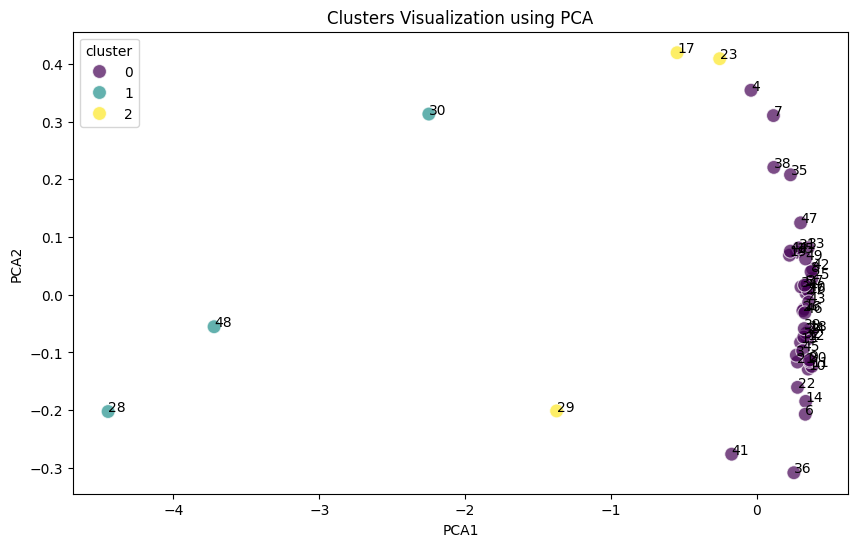

In [14]:
def perform_clustering_daily(corr_matrix, n_clusters=3):
    # Apply K-Means clustering on the correlation matrix
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(corr_matrix)
    
    # Map apartments to their clusters
    apartment_clusters = {apartment: clusters[i] for i, apartment in enumerate(corr_matrix.columns)}
    
    return apartment_clusters

def plot_clusters_scatter_daily(corr_matrix, apartment_clusters):
    # Create a DataFrame for the clusters
    cluster_df = corr_matrix.copy()
    cluster_df['cluster'] = [apartment_clusters[apartment] for apartment in corr_matrix.columns]
    
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(corr_matrix)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = cluster_df['cluster'].values
    pca_df['apartment_id'] = corr_matrix.columns
        
    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
        
    # Add labels for each point
    for i in range(pca_df.shape[0]):
        plt.text(pca_df['PCA1'][i], pca_df['PCA2'][i], pca_df['apartment_id'][i], fontsize=10)
        
    plt.title('Clusters Visualization using PCA')
    plt.show()

# Cluster assignment for each apartment
apartment_clusters = perform_clustering_daily(daily_corr)
# Plot the clusters
plot_clusters_scatter_daily(daily_corr, apartment_clusters)


Kernel Ridge Regression Model Score: 0.9114465020714747
Kernel Ridge Regression Model Score: 0.9682880475401773
Kernel Ridge Regression Model Score: 0.9366501206157052


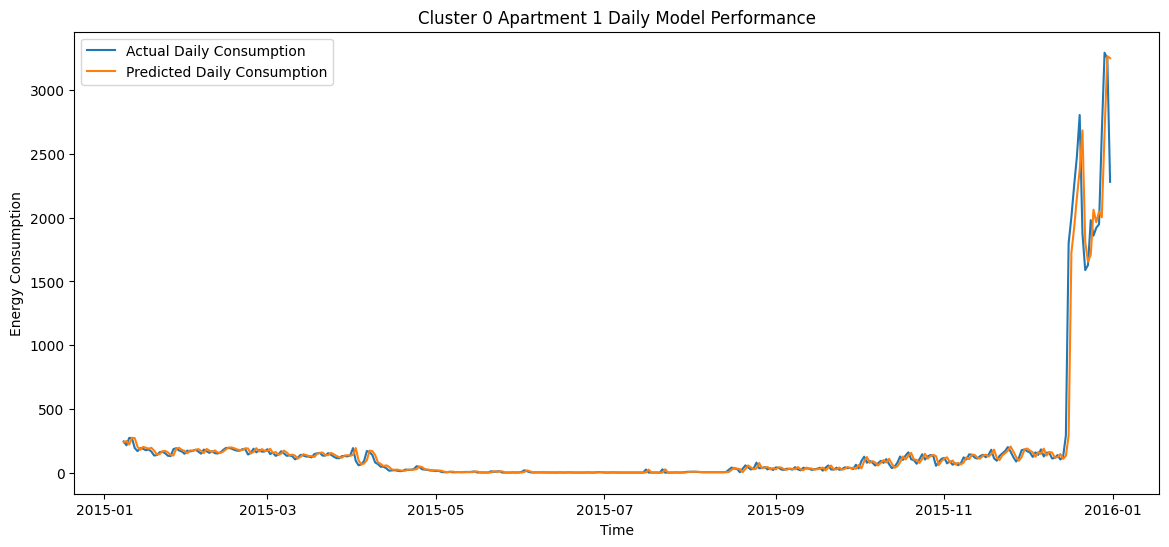

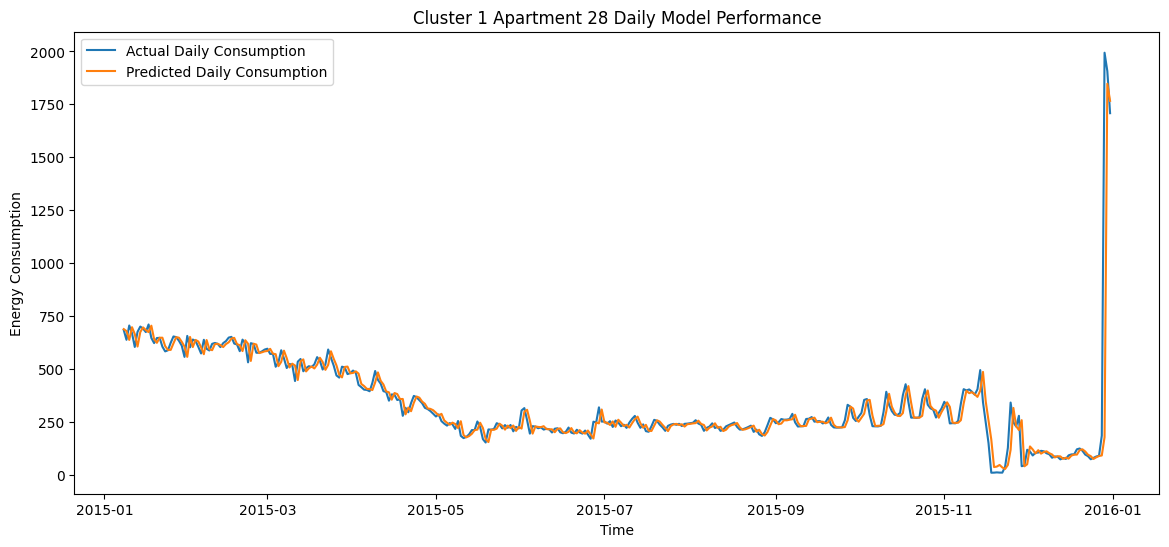

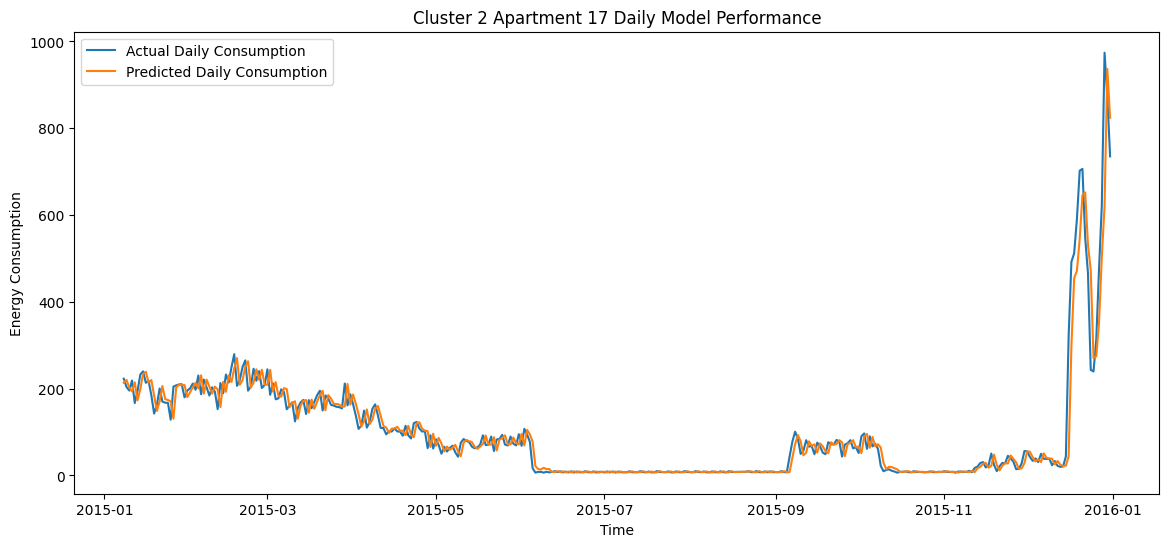

In [15]:
# Function to pull relevant data and train models for each cluster
def daily_cluster_specific_modeling(combine_data, apartment_clusters, n_clusters=3):
    cluster_models = {}
    
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        # Filter data for relevant apartments in this cluster
        cluster_data = combined_data[combine_data['apartment_id'].isin(cluster_apartments)]
        
        # Resample data to daily aggregations for each apartment
        cluster_data.set_index('time', inplace=True)
        
        daily_data = cluster_data.groupby('apartment_id')['energy_consumption'].resample('D').sum().reset_index()
        
        # Feature engineering - adding lagged features to daily data
        daily_data = add_lagged_features_daily(daily_data, lags=[1, 7])
        
        # Drop rows with NaN values from lagged features
        daily_data = daily_data.dropna()
        
        # Prepare training and testing sets for daily data
        X_daily = daily_data[['lag_1', 'lag_7']]
        y_daily = daily_data['energy_consumption']
        X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
        
        # Train a Kernel Ridge Regression model for daily data
        daily_model = fit_kernel_ridge_model_daily(X_train_daily, y_train_daily, X_test_daily, y_test_daily)
        
        # Store models for each cluster
        cluster_models[cluster] = {'daily_model': daily_model}
    
    return cluster_models

# Function to add lagged features
def add_lagged_features_daily(combine_data, lags=[1, 7]):
    for lag in lags:
        combine_data[f'lag_{lag}'] = combine_data.groupby('apartment_id')['energy_consumption'].shift(lag)
    return combine_data

# Function to fit Kernel Ridge Regression model
def fit_kernel_ridge_model_daily(X_train, y_train, X_test, y_test, alpha=0.1, gamma=0.9):
    # Initialize and fit the Kernel Ridge Regression model
    kr_model = KernelRidge(alpha=alpha, gamma=gamma)
    kr_model.fit(X_train, y_train)
    
    # Evaluate the model
    score = kr_model.score(X_test, y_test)
    print(f"Kernel Ridge Regression Model Score: {score}")
    
    return kr_model

# Train models for each cluster
cluster_models = daily_cluster_specific_modeling(combined_data, apartment_clusters)

# Visualize the model performance
def visualize_model_performance_daily(cluster_models, combine_data, apartment_clusters, n_clusters=3):
    for cluster in range(n_clusters):
        # Select apartments belonging to the current cluster
        cluster_apartments = [apt for apt, clus in apartment_clusters.items() if clus == cluster]
        
        if cluster_apartments:
            apartment = cluster_apartments[0]  # Select one apartment from the cluster
            # Filter data for the relevant apartment in this cluster
            apartment_data = combine_data[combine_data['apartment_id'] == apartment]
            
            # Resample data to daily aggregations for the apartment
            apartment_data.set_index('time', inplace=True)
            daily_data = apartment_data['energy_consumption'].resample('D').sum().reset_index()
            
            # Ensure daily_data has apartment_id as a column
            daily_data['apartment_id'] = apartment
            # Feature engineering - adding lagged features to daily data
            daily_data = add_lagged_features_daily(daily_data, lags=[1, 7])
            
            # Drop rows with NaN values from lagged features
            daily_data = daily_data.dropna()
            
            # Prepare data for daily model visualization
            X_daily = daily_data[['lag_1', 'lag_7']]
            y_daily = daily_data['energy_consumption']
            daily_model = cluster_models[cluster]['daily_model']
            y_pred_daily = daily_model.predict(X_daily)
            
            # Plot daily model performance for the apartment
            plt.figure(figsize=(14, 6))
            plt.plot(daily_data['time'], y_daily, label='Actual Daily Consumption')
            plt.plot(daily_data['time'], y_pred_daily, label='Predicted Daily Consumption')
            plt.title(f'Cluster {cluster} Apartment {apartment} Daily Model Performance')
            plt.xlabel('Time')
            plt.ylabel('Energy Consumption')
            plt.legend()
            plt.show()

# Visualize the model performance for each apartment in each cluster
visualize_model_performance_daily(cluster_models, combined_data, apartment_clusters)